In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm

# Load the data
# Go one folder back
os.chdir("..")

bh_path = "C:\\Users\\sapta\\OneDrive\\Documents\\GitHub\\M3Challenge2024\\data\\bh_homelessness.csv"
bh_hl = pd.read_csv(bh_path)

# Convert the Year column to datetime
bh_hl['Year'] = pd.to_datetime(bh_hl['Year'], format='%Y')

# Convert all other columns to numeric.
for col in bh_hl.columns[1:]:
    if bh_hl[col].dtype == 'object':
        # If data contains '-', use linear interpolation to fill missing values.
        if ' -' in bh_hl[col].unique():
            bh_hl[col] = bh_hl[col].replace(' -', np.nan)

        # Remove commas and convert to numeric
        bh_hl[col] = pd.to_numeric(bh_hl[col].str.replace(',', ''))

        bh_hl[col] = bh_hl[col].interpolate(method='linear')

print(bh_hl)


hl_path = "C:\\Users\\sapta\\OneDrive\\Documents\\GitHub\\M3Challenge2024\\data\\manchester_homelessness.csv"
manchester_hl = pd.read_csv(hl_path)

# Convert the Year column to datetime
manchester_hl['Year'] = pd.to_datetime(manchester_hl['Year'], format='%Y')

# Convert all other columns to numeric.
for col in manchester_hl.columns[1:]:
    if manchester_hl[col].dtype == 'object':
        # If data contains '-', use linear interpolation to fill missing values.
        if ' -' in manchester_hl[col].unique():
            manchester_hl[col] = manchester_hl[col].replace(' -', np.nan)

        # Remove commas and convert to numeric
        manchester_hl[col] = pd.to_numeric(manchester_hl[col].str.replace(',', ''))

        manchester_hl[col] = manchester_hl[col].interpolate(method='linear')

print(manchester_hl)

         Year  Total number of households  Homeless with priority need  \
0  2008-01-01                    116847.0                        554.0   
1  2009-01-01                    117000.0                        511.0   
2  2010-01-01                    115000.0                        568.0   
3  2011-01-01                    115000.0                        626.0   
4  2012-01-01                    122514.0                        620.0   
5  2013-01-01                    123558.0                        632.0   
6  2014-01-01                    124764.0                        546.0   
7  2015-01-01                    125995.0                        477.0   
8  2016-01-01                    128108.0                        488.0   
9  2017-01-01                    129492.0                        549.0   
10 2018-01-01                    129135.2                        534.4   
11 2019-01-01                    128778.4                        519.8   
12 2020-01-01                    12842

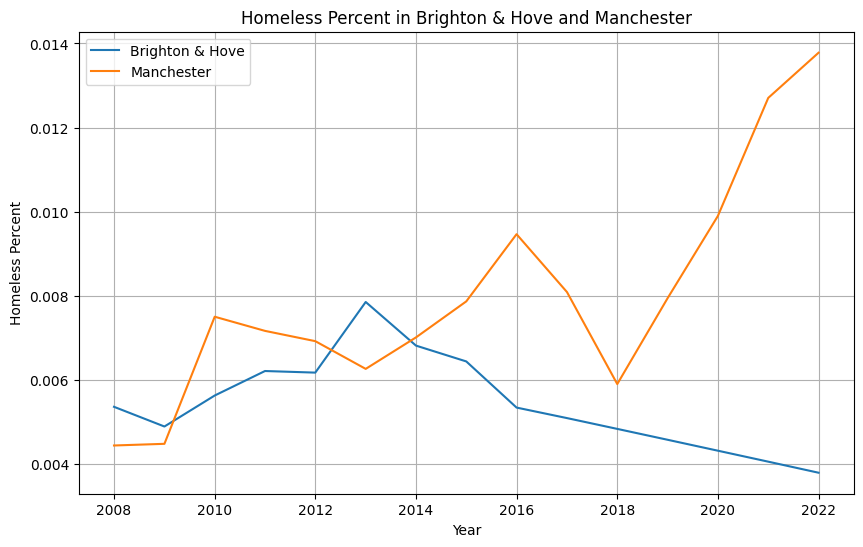

In [120]:
bh_hl['total homeless'] = bh_hl['Homeless with priority need'] + bh_hl['Homeless without priority need']
bh_hl['homeless percent'] = bh_hl['total homeless'] / bh_hl['Total number of households']

manchester_hl['total homeless'] = manchester_hl['Homeless with priority need'] + manchester_hl['Homeless without priority need']
manchester_hl['homeless percent'] = manchester_hl['total homeless'] / manchester_hl['Total number of households']

# Plot the homeless percent
plt.figure(figsize=(10, 6))
plt.plot(bh_hl['Year'], bh_hl['homeless percent'], label='Brighton & Hove')
plt.plot(manchester_hl['Year'], manchester_hl['homeless percent'], label='Manchester')
plt.xlabel('Year')
plt.ylabel('Homeless Percent')
plt.title('Homeless Percent in Brighton & Hove and Manchester')
plt.grid()
plt.legend()
plt.show()


In [121]:
# Fit Manchester data to a sine and logistic function
def sine(x, a, b, c, d):
    return a * np.sin(b * x + c) + d 

def logistic(x, a, b, c, d):
    return a / (1 + np.exp(-b * (x - c))) + d

def line(x, a, b):
    return a * x + b

def logistic_sine(x, a, b, c, d, e, f, g):
    return a / (1 + np.exp(-b * (x - c))) + d + e * np.sin(f * x + g)

def line_sine(x, a, b, c, d, e, f):
    return a * x + b + c * np.sin(d * x + e) + f

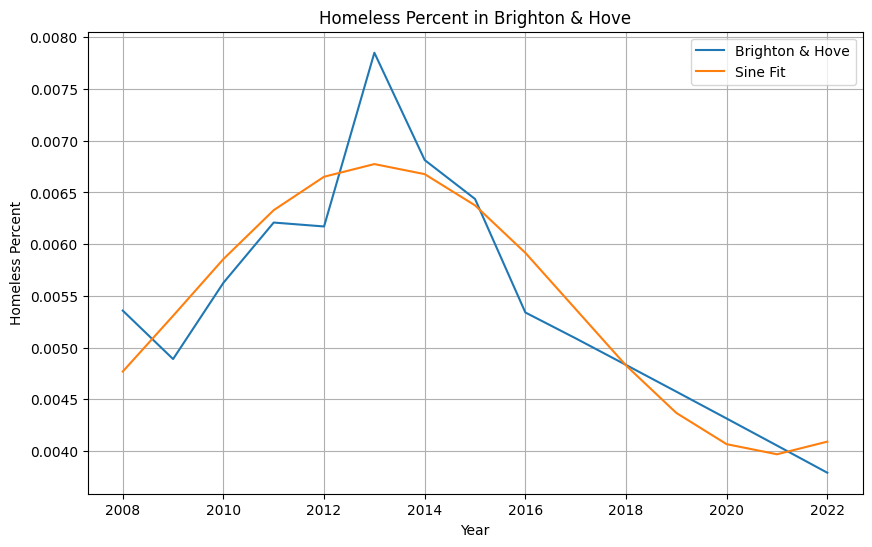

In [122]:
from scipy.optimize import curve_fit
from scipy.stats.distributions import t

popt1, pcov1 = curve_fit(sine, bh_hl['Year'].dt.year, bh_hl['homeless percent'], p0=[0.1, 0.1, 0.1, 0.1])

# Fit the logistic function
plt.figure(figsize=(10, 6))
plt.plot(bh_hl['Year'].dt.year, bh_hl['homeless percent'], label='Brighton & Hove')
plt.plot(bh_hl['Year'].dt.year, sine(bh_hl['Year'].dt.year, *popt1), label='Sine Fit')
plt.xlabel('Year')
plt.ylabel('Homeless Percent')
plt.title('Homeless Percent in Brighton & Hove')
plt.grid()
plt.legend()
plt.show()

C:\Users\sapta\AppData\Local\Temp\ipykernel_24424\3036846102.py:22: RuntimeWarning: invalid value encountered in sqrt
  ci = tval*np.sqrt(pcov1)


p0: 0.0014031555004349837 +/- 0.0003843942074127161
p1: 0.39840118293672033 +/- 0.08820739024613183
p2: -599.37193455479 +/- 177.6110292978477
p3: 0.005371119195804214 +/- 0.00036177178821163565

2031 0.62813085685134
2041 0.5562166039559127
2071 0.4725966008586568


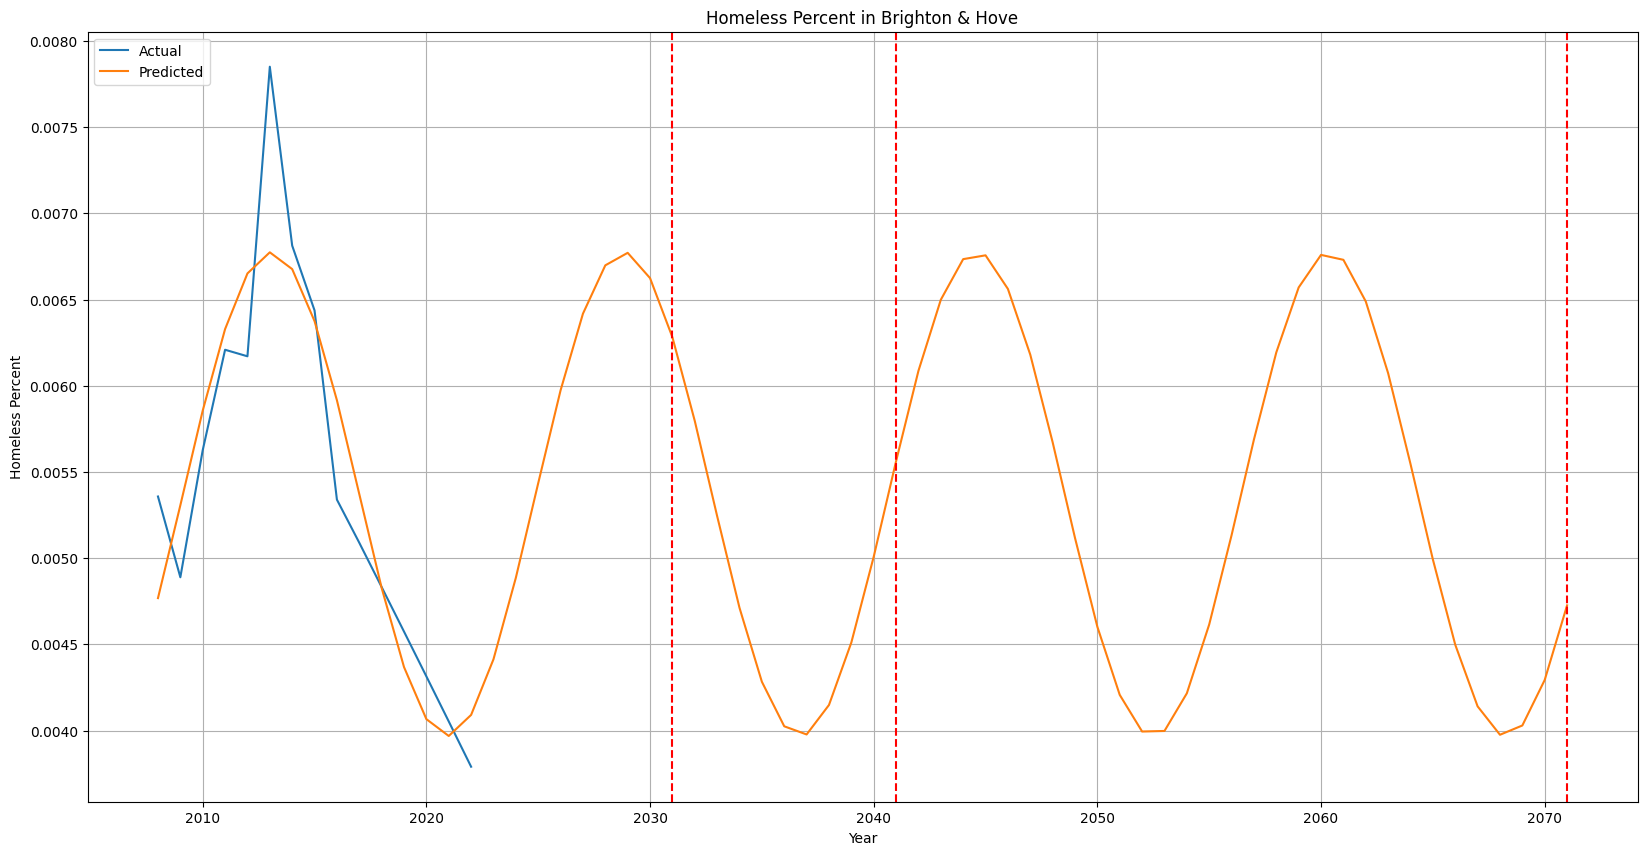

In [132]:
# Predict for the next 50 years.
time = np.arange(2008, 2072, 1)
pred = sine(time, *popt1)

plt.figure(figsize=(20, 10))
plt.plot(bh_hl['Year'].dt.year, bh_hl['homeless percent'], label='Brighton & Hove')
plt.plot(time, pred)
plt.xlabel('Year')
plt.ylabel('Homeless Percent')
plt.title('Homeless Percent in Brighton & Hove')
plt.grid()
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.axvline(x=2031, color='r', linestyle='--')
plt.axvline(x=2041, color='r', linestyle='--')
plt.axvline(x=2071, color='r', linestyle='--')

dof = np.size(bh_hl['Year'].dt.year) - 1 # degrees of freedom:
# calculate student-t value
a = 0.05 #(1-0.95, 95% CI)
tval = t.ppf(1.0-a/2, dof)

ci = tval*np.sqrt(pcov1)
for i in range(len(popt1)):
    print("p{0}: {1} +/- {2}".format(i, popt1[i], ci[i, i]))

print('\n2031', pred[2031 - 2008]*100)
print('2041', pred[2041 - 2008]*100)
print('2071', pred[2071 - 2008]*100)

plt.show()

c:\Users\sapta\OneDrive\Documents\GitHub\M3Challenge2024\venv\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\sapta\OneDrive\Documents\GitHub\M3Challenge2024\venv\lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


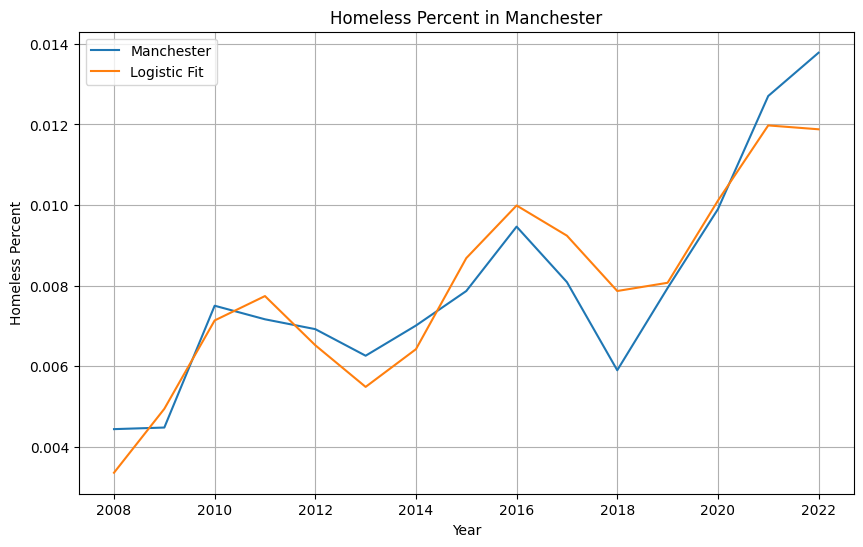

In [124]:
# Fit the data to logistic_sine using scipy

popt2, pcov2 = curve_fit(logistic_sine, manchester_hl['Year'].dt.year, manchester_hl['homeless percent'],
                          p0=[0.1, 0.5, 2000, 40, 0.1, 1, 1])

popt3, pcov3 = curve_fit(line_sine, manchester_hl['Year'].dt.year, manchester_hl['homeless percent'],
                          p0=[0.1, 0.5, 4000, 30, 0.1, 1])

# Plot the data and the fitted curve
plt.figure(figsize=(10, 6))
plt.plot(manchester_hl['Year'].dt.year, manchester_hl['homeless percent'], label='Manchester')
# plt.plot(manchester_hl['Year'], logistic_sine(manchester_hl['Year'].dt.year, *popt), label='Logistic Sine Fit')
plt.plot(manchester_hl['Year'].dt.year, line_sine(manchester_hl['Year'].dt.year, *popt3), label='Logistic Fit')
plt.xlabel('Year')
plt.ylabel('Homeless Percent')
plt.title('Homeless Percent in Manchester')
plt.grid()
plt.legend()
plt.show()

2031 1.5252288951160153
2041 1.8080352991091786
2071 3.0312260289065307


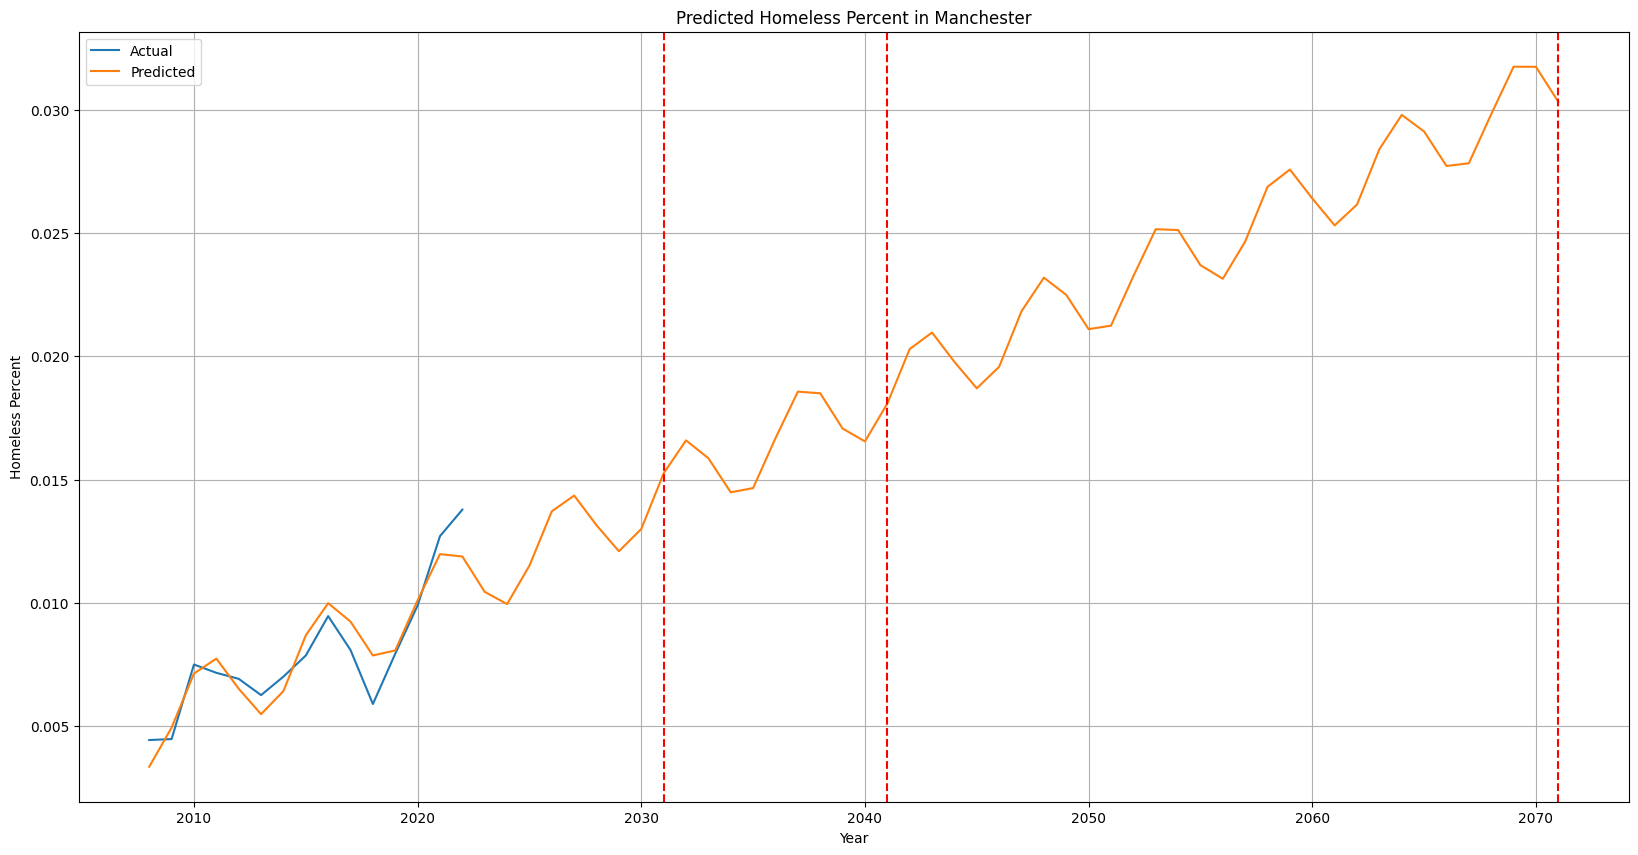

In [131]:
# Predict for the next 50 years.
time = np.arange(2008, 2072, 1)
pred = line_sine(time, *popt3)

plt.figure(figsize=(20, 10))
plt.plot(manchester_hl['Year'].dt.year, manchester_hl['homeless percent'], label='Manchester')
plt.plot(time, pred)
plt.xlabel('Year')
plt.ylabel('Homeless Percent')
plt.title('Predicted Homeless Percent in Manchester')
plt.grid()
plt.legend(['Actual', 'Predicted'], loc='upper left')
plt.axvline(x=2031, color='r', linestyle='--')
plt.axvline(x=2041, color='r', linestyle='--')
plt.axvline(x=2071, color='r', linestyle='--')

print('2031', pred[2031 - 2008]*100)
print('2041', pred[2041 - 2008]*100)
print('2071', pred[2071 - 2008]*100)

plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
test_result=adfuller(manchester_hl['homeless percent'])
test_result

(-0.32427371748085376,
 0.9219953957164571,
 0,
 14,
 {'1%': -4.01203360058309,
  '5%': -3.1041838775510207,
  '10%': -2.6909873469387753},
 -87.06925190495656)

In [ ]:
manchester_hl['Seasonal first difference'] = manchester_hl['total homeless'] - manchester_hl['total homeless'].shift(6)
manchester_hl.head(14)

,Year,Total number of households,Homeless with priority need,Homeless without priority need,Eligible but not homeless,total homeless,homeless percent,Seasonal first difference
0,2008-01-01,196504,745.0,127.0,158.0,872.0,0.004438,NaN
1,2009-01-01,197000,703.0,179.0,208.0,882.0,0.004477,NaN
2,2010-01-01,202000,880.0,635.0,807.0,1515.0,0.007500,NaN
3,2011-01-01,202000,794.0,653.0,758.0,1447.0,0.007163,NaN
4,2012-01-01,207981,770.0,669.0,878.0,1439.0,0.006919,NaN
5,2013-01-01,209925,777.0,537.0,948.0,1314.0,0.006259,NaN
6,2014-01-01,212314,1020.0,468.0,715.0,1488.0,0.007008,616.0
7,2015-01-01,214753,1141.0,548.0,582.0,1689.0,0.007865,807.0
8,2016-01-01,220121,1447.0,636.0,695.0,2083.0,0.009463,568.0
9,2017-01-01,223092,1394.0,410.0,1075.0,1804.0,0.008086,357.0


In [ ]:
adfuller(manchester_hl['Seasonal first difference'].dropna())

(-2.9774645423821022,
 0.03705319777466971,
 2,
 6,
 {'1%': -5.354256481481482,
  '5%': -3.6462381481481483,
  '10%': -2.901197777777778},
 86.00208634204952)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(manchester_hl['Year'])
result.plot()

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(manchester_hl['Year'], manchester_hl['homeless percent'], train_size=0.8, test_size=0.2, shuffle=False)

X_train, X_test, y_train, y_test = X_train.to_frame(), X_test.to_frame(), y_train.to_frame(), y_test.to_frame()

regr = make_pipeline(StandardScaler(), SVR(C=0.5, epsilon=5))

regr.fit(X_train, y_train)
forecasts = regr.predict(X_test)

# x = np.arange(X_train + X_test)
plt.plot(X_train, y_train, c='blue')
plt.plot(X_test, y_test, c='red')
plt.plot(X_test, forecasts, c='green')
plt.show()

In [ ]:
import pmdarima as pm
from sklearn.model_selection import train_test_split

manchester_hl['total homeless'] = manchester_hl['Homeless with priority need'] + manchester_hl['Homeless without priority need']

manchester_hl['homeless percent'] = manchester_hl['total homeless'] / manchester_hl['Total number of households']

X_train, X_test, y_train, y_test = train_test_split(manchester_hl['Year'], manchester_hl['total homeless'], train_size=0.7, shuffle=False)

model = pm.auto_arima(y_train, seasonal=True, m=3, seasonal_test='ch')

forecasts = model.predict(X_test.shape[0])

# x = np.arange(X_train + X_test)
plt.plot(X_train, y_train, c='blue')
plt.plot(X_test, y_test, c='red')
plt.plot(X_test, forecasts, c='green')
plt.show()